# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

keywords are unexpanded, not using


In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  1.258544  2.129820  1.0  0.797769 -0.605014 -1.169768  1  2  24.027582   
1  1.091218 -2.189487  1.0  0.794996  1.710210 -2.237403  1  1  24.482024   
2  2.059486 -0.659859  1.0  0.333734 -0.129255 -0.492015  2  3  29.929954   
3  2.197430 -1.909390  0.0  0.406263 -1.636095 -0.710631  2  0   0.575499   
4 -0.964509 -0.241297  1.0  0.748820 -0.064859 -3.279791  1  1  15.541642   

            y  
0  402.829415  
1  372.890215  
2  624.141434  
3    5.714043  
4   64.724491  
True causal estimate is 13.19637505735844


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

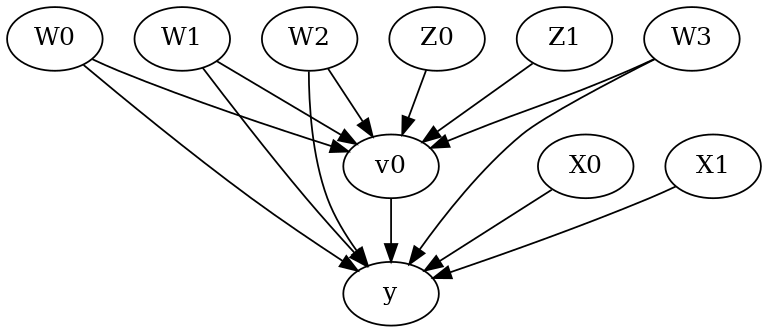

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

linear_regression


{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['X0', 'X1']}


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W3+v0*X0+v0*X1
Target units: ate

## Estimate
Mean value: 13.196492210626094
### Conditional Estimates
__categorical__X0              __categorical__X1           
(-2.8289999999999997, -0.216]  (-4.688000000000001, -1.767]     5.770160
                               (-1.767, -1.18]                  5.893190
                               (-1.18, -0.675]                  6.197866
                               (-0.675, -0.077]                 5.976549
                               (-0.077, 2.674]                  6.169252
(-0.216, 0.37]                 (-4.688000000000001, -1.767]    10.274096
                               (-1.7

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W3 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 18.67316477598737
Effect estimates: [16.62699508 15.43145508 20.6754809  ... 17.69202115 26.66410926
 20.28438648]



In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 13.19637505735844


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W3 | X0,X1
Target units: 

## Estimate
Mean value: 13.057634722367434
Effect estimates: [16.50486153 15.28267492 20.41717001 ... 26.2640249   7.91758061
 20.0269626 ]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W3 | X0,X1
Target units: ate

## Estimate
Mean value: 13.094586461425834
Effect estimates: [16.61614591 15.3439143  20.56699654 ... 26.50536559  7.88263041
 20.16597162]
95.0% confidence interval: (array([16.5859178 , 15.34081364, 20.75254116, ..., 26.7739508 ,
        7.69233251, 20.32404914]), array([17.21381411, 15.67761979, 21.17191659, ..., 27.44937061,
        7.92195237, 20.74332049]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[13.10639861 11.10009197 12.54694698 14.12410541 14.08158394 11.98149441
 14.64809109 13.99594984 13.94558482 10.79352241]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -0.584677  1.089316  1.0  0.548076 -0.227897 -1.311306  0.402038   
1     1.234122  0.064014  1.0  0.908699  2.165168  0.195968  0.705985   
2    -2.659472  0.254258  1.0  0.603676  0.665055 -1.251308 -0.107299   
3     0.084122 -1.671313  1.0  0.359915 -1.166315  0.783538  1.795441   
4     0.020122  0.408734  1.0  0.519498  0.546777 -0.042630  0.178960   
...        ...       ...  ...       ...       ...       ...       ...   
9995  1.036484  0.416189  0.0  0.165905 -1.794482 -0.467813 -2.699554   
9996  1.489992 -1.769611  1.0  0.759906  0.436725 -2.343717  0.017761   
9997 -0.239153  0.005021  0.0  0.273494  0.032690 -0.396297  0.443913   
9998 -0.076927  1.209578  0.0  0.154725  1.794436 -0.024288  0.208574   
9999 -0.352615 -0.344775  1.0  0.435162  2.554170 -0.611231  1.057468   

            W3  v0  y  
0    -0.537449   1  1  
1    -1.704815   1  1  
2    -0.595494   1  0  
3    -1.341975   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W3 | X0,X1
Target units: ate

## Estimate
Mean value: 0.5829637729770526
Effect estimates: [0.60082202 0.62692296 0.47759895 ... 0.56431552 0.62705736 0.54339982]

True causal estimate is 0.3936


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-07-28 10:28:48.302410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /__t/Python/3.10.5/x64/lib
2022-07-28 10:28:48.302450: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-07-28 10:28:50.314729: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /__t/Python/3.10.5/x64/lib
2022-07-28 10:28:50.314770: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-28 10:28:50.314795: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ecafc1dbd241): /proc/driver/nvidia/version does not exist
2022-07-28 10:28:50.315489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 4:19 - loss: 125.8065

 28/313 [=>............................] - ETA: 0s - loss: 44.8289   

 55/313 [====>.........................] - ETA: 0s - loss: 25.4310

 82/313 [======>.......................] - ETA: 0s - loss: 18.5148

108/313 [=========>....................] - ETA: 0s - loss: 15.0590

135/313 [===========>..................] - ETA: 0s - loss: 12.8746

163/313 [==============>...............] - ETA: 0s - loss: 11.3526

190/313 [=================>............] - ETA: 0s - loss: 10.3113

217/313 [===================>..........] - ETA: 0s - loss: 9.5209 

244/313 [======================>.......] - ETA: 0s - loss: 8.8967

269/313 [========================>.....] - ETA: 0s - loss: 8.4207

298/313 [===========================>..] - ETA: 0s - loss: 7.9739

313/313 [==============================] - 1s 2ms/step - loss: 7.7727


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 3.6983

 29/313 [=>............................] - ETA: 0s - loss: 3.7048

 57/313 [====>.........................] - ETA: 0s - loss: 3.6757

 86/313 [=======>......................] - ETA: 0s - loss: 3.6749

114/313 [=========>....................] - ETA: 0s - loss: 3.6591

142/313 [============>.................] - ETA: 0s - loss: 3.6328

171/313 [===============>..............] - ETA: 0s - loss: 3.6282

195/313 [=================>............] - ETA: 0s - loss: 3.6205

222/313 [====================>.........] - ETA: 0s - loss: 3.5850

249/313 [======================>.......] - ETA: 0s - loss: 3.5575

277/313 [=========================>....] - ETA: 0s - loss: 3.5246

305/313 [============================>.] - ETA: 0s - loss: 3.4943

313/313 [==============================] - 1s 2ms/step - loss: 3.4837


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 3.4231

 29/313 [=>............................] - ETA: 0s - loss: 3.1783

 56/313 [====>.........................] - ETA: 0s - loss: 3.1663

 84/313 [=======>......................] - ETA: 0s - loss: 3.1261

111/313 [=========>....................] - ETA: 0s - loss: 3.1017

140/313 [============>.................] - ETA: 0s - loss: 3.0765

167/313 [===============>..............] - ETA: 0s - loss: 3.0581

195/313 [=================>............] - ETA: 0s - loss: 3.0399

223/313 [====================>.........] - ETA: 0s - loss: 3.0263

251/313 [=======================>......] - ETA: 0s - loss: 3.0105

280/313 [=========================>....] - ETA: 0s - loss: 2.9950

309/313 [============================>.] - ETA: 0s - loss: 2.9844

313/313 [==============================] - 1s 2ms/step - loss: 2.9824


Epoch 4/25


  1/313 [..............................] - ETA: 0s - loss: 2.7908

 30/313 [=>............................] - ETA: 0s - loss: 2.8339

 54/313 [====>.........................] - ETA: 0s - loss: 2.8677

 80/313 [======>.......................] - ETA: 0s - loss: 2.8659

108/313 [=========>....................] - ETA: 0s - loss: 2.8645

134/313 [===========>..................] - ETA: 0s - loss: 2.8564

162/313 [==============>...............] - ETA: 0s - loss: 2.8563

191/313 [=================>............] - ETA: 0s - loss: 2.8548

219/313 [===================>..........] - ETA: 0s - loss: 2.8469

248/313 [======================>.......] - ETA: 0s - loss: 2.8413

277/313 [=========================>....] - ETA: 0s - loss: 2.8380

304/313 [============================>.] - ETA: 0s - loss: 2.8364

313/313 [==============================] - 1s 2ms/step - loss: 2.8340


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 2.8408

 31/313 [=>............................] - ETA: 0s - loss: 2.7534

 60/313 [====>.........................] - ETA: 0s - loss: 2.7620

 88/313 [=======>......................] - ETA: 0s - loss: 2.7898

115/313 [==========>...................] - ETA: 0s - loss: 2.7904

142/313 [============>.................] - ETA: 0s - loss: 2.7935

171/313 [===============>..............] - ETA: 0s - loss: 2.7896

198/313 [=================>............] - ETA: 0s - loss: 2.7852

226/313 [====================>.........] - ETA: 0s - loss: 2.7858

254/313 [=======================>......] - ETA: 0s - loss: 2.7869

283/313 [==========================>...] - ETA: 0s - loss: 2.7821

312/313 [============================>.] - ETA: 0s - loss: 2.7793

313/313 [==============================] - 1s 2ms/step - loss: 2.7783


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 2.5882

 30/313 [=>............................] - ETA: 0s - loss: 2.8091

 57/313 [====>.........................] - ETA: 0s - loss: 2.7901

 84/313 [=======>......................] - ETA: 0s - loss: 2.7685

112/313 [=========>....................] - ETA: 0s - loss: 2.7632

139/313 [============>.................] - ETA: 0s - loss: 2.7650

168/313 [===============>..............] - ETA: 0s - loss: 2.7604

197/313 [=================>............] - ETA: 0s - loss: 2.7600

227/313 [====================>.........] - ETA: 0s - loss: 2.7559

256/313 [=======================>......] - ETA: 0s - loss: 2.7507

285/313 [==========================>...] - ETA: 0s - loss: 2.7516

313/313 [==============================] - 1s 2ms/step - loss: 2.7499


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 2.8037

 30/313 [=>............................] - ETA: 0s - loss: 2.7640

 58/313 [====>.........................] - ETA: 0s - loss: 2.7485

 86/313 [=======>......................] - ETA: 0s - loss: 2.7376

112/313 [=========>....................] - ETA: 0s - loss: 2.7401

139/313 [============>.................] - ETA: 0s - loss: 2.7376

168/313 [===============>..............] - ETA: 0s - loss: 2.7319

196/313 [=================>............] - ETA: 0s - loss: 2.7291

224/313 [====================>.........] - ETA: 0s - loss: 2.7313

252/313 [=======================>......] - ETA: 0s - loss: 2.7268

277/313 [=========================>....] - ETA: 0s - loss: 2.7294

306/313 [============================>.] - ETA: 0s - loss: 2.7272

313/313 [==============================] - 1s 2ms/step - loss: 2.7280


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 2.9092

 29/313 [=>............................] - ETA: 0s - loss: 2.7193

 57/313 [====>.........................] - ETA: 0s - loss: 2.6940

 83/313 [======>.......................] - ETA: 0s - loss: 2.6973

111/313 [=========>....................] - ETA: 0s - loss: 2.7108

139/313 [============>.................] - ETA: 0s - loss: 2.7154

167/313 [===============>..............] - ETA: 0s - loss: 2.7145

195/313 [=================>............] - ETA: 0s - loss: 2.7156

223/313 [====================>.........] - ETA: 0s - loss: 2.7093

251/313 [=======================>......] - ETA: 0s - loss: 2.7098

277/313 [=========================>....] - ETA: 0s - loss: 2.7095

302/313 [===========================>..] - ETA: 0s - loss: 2.7084

313/313 [==============================] - 1s 2ms/step - loss: 2.7101


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2.4027

 28/313 [=>............................] - ETA: 0s - loss: 2.6923

 56/313 [====>.........................] - ETA: 0s - loss: 2.6824

 82/313 [======>.......................] - ETA: 0s - loss: 2.6723

109/313 [=========>....................] - ETA: 0s - loss: 2.6905

137/313 [============>.................] - ETA: 0s - loss: 2.6989

164/313 [==============>...............] - ETA: 0s - loss: 2.7040

191/313 [=================>............] - ETA: 0s - loss: 2.7025

219/313 [===================>..........] - ETA: 0s - loss: 2.6978

247/313 [======================>.......] - ETA: 0s - loss: 2.7029

276/313 [=========================>....] - ETA: 0s - loss: 2.6960

304/313 [============================>.] - ETA: 0s - loss: 2.7009

313/313 [==============================] - 1s 2ms/step - loss: 2.7003


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 2.7405

 28/313 [=>............................] - ETA: 0s - loss: 2.7205

 56/313 [====>.........................] - ETA: 0s - loss: 2.7035

 84/313 [=======>......................] - ETA: 0s - loss: 2.7050

112/313 [=========>....................] - ETA: 0s - loss: 2.6934

140/313 [============>.................] - ETA: 0s - loss: 2.6912

168/313 [===============>..............] - ETA: 0s - loss: 2.6858

194/313 [=================>............] - ETA: 0s - loss: 2.6845

215/313 [===================>..........] - ETA: 0s - loss: 2.6856

243/313 [======================>.......] - ETA: 0s - loss: 2.6838

271/313 [========================>.....] - ETA: 0s - loss: 2.6830

298/313 [===========================>..] - ETA: 0s - loss: 2.6848

313/313 [==============================] - 1s 2ms/step - loss: 2.6884


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2.7158

 29/313 [=>............................] - ETA: 0s - loss: 2.6656

 57/313 [====>.........................] - ETA: 0s - loss: 2.6838

 85/313 [=======>......................] - ETA: 0s - loss: 2.6977

113/313 [=========>....................] - ETA: 0s - loss: 2.6920

142/313 [============>.................] - ETA: 0s - loss: 2.6927

170/313 [===============>..............] - ETA: 0s - loss: 2.6989

198/313 [=================>............] - ETA: 0s - loss: 2.6957

226/313 [====================>.........] - ETA: 0s - loss: 2.6975

253/313 [=======================>......] - ETA: 0s - loss: 2.6931

281/313 [=========================>....] - ETA: 0s - loss: 2.6899

308/313 [============================>.] - ETA: 0s - loss: 2.6912

313/313 [==============================] - 1s 2ms/step - loss: 2.6930


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 2.7709

 26/313 [=>............................] - ETA: 0s - loss: 2.7164

 54/313 [====>.........................] - ETA: 0s - loss: 2.6893

 83/313 [======>.......................] - ETA: 0s - loss: 2.6699

110/313 [=========>....................] - ETA: 0s - loss: 2.6753

138/313 [============>.................] - ETA: 0s - loss: 2.6847

165/313 [==============>...............] - ETA: 0s - loss: 2.6812

193/313 [=================>............] - ETA: 0s - loss: 2.6815

220/313 [====================>.........] - ETA: 0s - loss: 2.6874

245/313 [======================>.......] - ETA: 0s - loss: 2.6853

272/313 [=========================>....] - ETA: 0s - loss: 2.6821

299/313 [===========================>..] - ETA: 0s - loss: 2.6801

313/313 [==============================] - 1s 2ms/step - loss: 2.6750


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 2.8426

 27/313 [=>............................] - ETA: 0s - loss: 2.6666

 55/313 [====>.........................] - ETA: 0s - loss: 2.6746

 81/313 [======>.......................] - ETA: 0s - loss: 2.6635

107/313 [=========>....................] - ETA: 0s - loss: 2.6686

131/313 [===========>..................] - ETA: 0s - loss: 2.6663

158/313 [==============>...............] - ETA: 0s - loss: 2.6687

185/313 [================>.............] - ETA: 0s - loss: 2.6699

212/313 [===================>..........] - ETA: 0s - loss: 2.6692

240/313 [======================>.......] - ETA: 0s - loss: 2.6667

268/313 [========================>.....] - ETA: 0s - loss: 2.6613

296/313 [===========================>..] - ETA: 0s - loss: 2.6564

313/313 [==============================] - 1s 2ms/step - loss: 2.6545


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2.7868

 29/313 [=>............................] - ETA: 0s - loss: 2.6426

 55/313 [====>.........................] - ETA: 0s - loss: 2.6167

 82/313 [======>.......................] - ETA: 0s - loss: 2.6251

109/313 [=========>....................] - ETA: 0s - loss: 2.6227

136/313 [============>.................] - ETA: 0s - loss: 2.6334

162/313 [==============>...............] - ETA: 0s - loss: 2.6320

189/313 [=================>............] - ETA: 0s - loss: 2.6296

218/313 [===================>..........] - ETA: 0s - loss: 2.6366

246/313 [======================>.......] - ETA: 0s - loss: 2.6346

274/313 [=========================>....] - ETA: 0s - loss: 2.6315

302/313 [===========================>..] - ETA: 0s - loss: 2.6267

313/313 [==============================] - 1s 2ms/step - loss: 2.6291


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 2.5815

 29/313 [=>............................] - ETA: 0s - loss: 2.6040

 56/313 [====>.........................] - ETA: 0s - loss: 2.6267

 84/313 [=======>......................] - ETA: 0s - loss: 2.6225

110/313 [=========>....................] - ETA: 0s - loss: 2.6197

137/313 [============>.................] - ETA: 0s - loss: 2.6253

165/313 [==============>...............] - ETA: 0s - loss: 2.6242

192/313 [=================>............] - ETA: 0s - loss: 2.6229

219/313 [===================>..........] - ETA: 0s - loss: 2.6230

246/313 [======================>.......] - ETA: 0s - loss: 2.6178

273/313 [=========================>....] - ETA: 0s - loss: 2.6192

300/313 [===========================>..] - ETA: 0s - loss: 2.6189

313/313 [==============================] - 1s 2ms/step - loss: 2.6178


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 2.4723

 27/313 [=>............................] - ETA: 0s - loss: 2.6116

 53/313 [====>.........................] - ETA: 0s - loss: 2.6074

 80/313 [======>.......................] - ETA: 0s - loss: 2.6184

106/313 [=========>....................] - ETA: 0s - loss: 2.6085

134/313 [===========>..................] - ETA: 0s - loss: 2.6059

160/313 [==============>...............] - ETA: 0s - loss: 2.6088

184/313 [================>.............] - ETA: 0s - loss: 2.6068

209/313 [===================>..........] - ETA: 0s - loss: 2.6110

234/313 [=====================>........] - ETA: 0s - loss: 2.6087

260/313 [=======================>......] - ETA: 0s - loss: 2.6066

285/313 [==========================>...] - ETA: 0s - loss: 2.6054

307/313 [============================>.] - ETA: 0s - loss: 2.6063

313/313 [==============================] - 1s 2ms/step - loss: 2.6057


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.5392

 28/313 [=>............................] - ETA: 0s - loss: 2.6185

 54/313 [====>.........................] - ETA: 0s - loss: 2.6327

 82/313 [======>.......................] - ETA: 0s - loss: 2.6200

109/313 [=========>....................] - ETA: 0s - loss: 2.6110

137/313 [============>.................] - ETA: 0s - loss: 2.6077

165/313 [==============>...............] - ETA: 0s - loss: 2.6067

193/313 [=================>............] - ETA: 0s - loss: 2.6060

220/313 [====================>.........] - ETA: 0s - loss: 2.6090

245/313 [======================>.......] - ETA: 0s - loss: 2.6132

270/313 [========================>.....] - ETA: 0s - loss: 2.6126

298/313 [===========================>..] - ETA: 0s - loss: 2.6114

313/313 [==============================] - 1s 2ms/step - loss: 2.6159


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 2.4472

 28/313 [=>............................] - ETA: 0s - loss: 2.5875

 56/313 [====>.........................] - ETA: 0s - loss: 2.5864

 85/313 [=======>......................] - ETA: 0s - loss: 2.5942

112/313 [=========>....................] - ETA: 0s - loss: 2.6123

136/313 [============>.................] - ETA: 0s - loss: 2.6099

160/313 [==============>...............] - ETA: 0s - loss: 2.6058

187/313 [================>.............] - ETA: 0s - loss: 2.6057

214/313 [===================>..........] - ETA: 0s - loss: 2.6047

242/313 [======================>.......] - ETA: 0s - loss: 2.6003

269/313 [========================>.....] - ETA: 0s - loss: 2.6020

297/313 [===========================>..] - ETA: 0s - loss: 2.6041

313/313 [==============================] - 1s 2ms/step - loss: 2.6046


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 2.5280

 29/313 [=>............................] - ETA: 0s - loss: 2.5531

 57/313 [====>.........................] - ETA: 0s - loss: 2.5563

 84/313 [=======>......................] - ETA: 0s - loss: 2.5702

113/313 [=========>....................] - ETA: 0s - loss: 2.5691

141/313 [============>.................] - ETA: 0s - loss: 2.5783

168/313 [===============>..............] - ETA: 0s - loss: 2.5843

194/313 [=================>............] - ETA: 0s - loss: 2.5876

219/313 [===================>..........] - ETA: 0s - loss: 2.5913

247/313 [======================>.......] - ETA: 0s - loss: 2.5950

276/313 [=========================>....] - ETA: 0s - loss: 2.5954

304/313 [============================>.] - ETA: 0s - loss: 2.5974

313/313 [==============================] - 1s 2ms/step - loss: 2.5974


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 2.4182

 30/313 [=>............................] - ETA: 0s - loss: 2.5928

 56/313 [====>.........................] - ETA: 0s - loss: 2.5924

 83/313 [======>.......................] - ETA: 0s - loss: 2.5869

111/313 [=========>....................] - ETA: 0s - loss: 2.5878

139/313 [============>.................] - ETA: 0s - loss: 2.5860

168/313 [===============>..............] - ETA: 0s - loss: 2.5862

196/313 [=================>............] - ETA: 0s - loss: 2.5918

223/313 [====================>.........] - ETA: 0s - loss: 2.5938

250/313 [======================>.......] - ETA: 0s - loss: 2.5963

277/313 [=========================>....] - ETA: 0s - loss: 2.5983

305/313 [============================>.] - ETA: 0s - loss: 2.5987

313/313 [==============================] - 1s 2ms/step - loss: 2.6014


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2.5349

 28/313 [=>............................] - ETA: 0s - loss: 2.6093

 55/313 [====>.........................] - ETA: 0s - loss: 2.6043

 82/313 [======>.......................] - ETA: 0s - loss: 2.5968

110/313 [=========>....................] - ETA: 0s - loss: 2.5999

138/313 [============>.................] - ETA: 0s - loss: 2.5820

166/313 [==============>...............] - ETA: 0s - loss: 2.5863

194/313 [=================>............] - ETA: 0s - loss: 2.5847

222/313 [====================>.........] - ETA: 0s - loss: 2.5895

246/313 [======================>.......] - ETA: 0s - loss: 2.5878

273/313 [=========================>....] - ETA: 0s - loss: 2.5898

297/313 [===========================>..] - ETA: 0s - loss: 2.5888

313/313 [==============================] - 1s 2ms/step - loss: 2.5890


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 2.5086

 28/313 [=>............................] - ETA: 0s - loss: 2.5684

 56/313 [====>.........................] - ETA: 0s - loss: 2.5968

 82/313 [======>.......................] - ETA: 0s - loss: 2.5950

110/313 [=========>....................] - ETA: 0s - loss: 2.5914

138/313 [============>.................] - ETA: 0s - loss: 2.5892

166/313 [==============>...............] - ETA: 0s - loss: 2.5944

194/313 [=================>............] - ETA: 0s - loss: 2.5924

223/313 [====================>.........] - ETA: 0s - loss: 2.5902

251/313 [=======================>......] - ETA: 0s - loss: 2.5914

278/313 [=========================>....] - ETA: 0s - loss: 2.5884

306/313 [============================>.] - ETA: 0s - loss: 2.5905

313/313 [==============================] - 1s 2ms/step - loss: 2.5900


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2.5198

 29/313 [=>............................] - ETA: 0s - loss: 2.6522

 58/313 [====>.........................] - ETA: 0s - loss: 2.6099

 87/313 [=======>......................] - ETA: 0s - loss: 2.5871

114/313 [=========>....................] - ETA: 0s - loss: 2.5882

142/313 [============>.................] - ETA: 0s - loss: 2.5869

170/313 [===============>..............] - ETA: 0s - loss: 2.5798

199/313 [==================>...........] - ETA: 0s - loss: 2.5785

227/313 [====================>.........] - ETA: 0s - loss: 2.5826

255/313 [=======================>......] - ETA: 0s - loss: 2.5824

283/313 [==========================>...] - ETA: 0s - loss: 2.5863

311/313 [============================>.] - ETA: 0s - loss: 2.5879

313/313 [==============================] - 1s 2ms/step - loss: 2.5870


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 2.6797

 30/313 [=>............................] - ETA: 0s - loss: 2.5961

 57/313 [====>.........................] - ETA: 0s - loss: 2.5922

 83/313 [======>.......................] - ETA: 0s - loss: 2.5822

109/313 [=========>....................] - ETA: 0s - loss: 2.5810

136/313 [============>.................] - ETA: 0s - loss: 2.5798

164/313 [==============>...............] - ETA: 0s - loss: 2.5864

192/313 [=================>............] - ETA: 0s - loss: 2.5848

220/313 [====================>.........] - ETA: 0s - loss: 2.5844

248/313 [======================>.......] - ETA: 0s - loss: 2.5850

276/313 [=========================>....] - ETA: 0s - loss: 2.5881

305/313 [============================>.] - ETA: 0s - loss: 2.5846

313/313 [==============================] - 1s 2ms/step - loss: 2.5864


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 2.6061

 29/313 [=>............................] - ETA: 0s - loss: 2.5923

 56/313 [====>.........................] - ETA: 0s - loss: 2.5896

 83/313 [======>.......................] - ETA: 0s - loss: 2.5751

109/313 [=========>....................] - ETA: 0s - loss: 2.5876

137/313 [============>.................] - ETA: 0s - loss: 2.5878

164/313 [==============>...............] - ETA: 0s - loss: 2.5920

192/313 [=================>............] - ETA: 0s - loss: 2.5880

220/313 [====================>.........] - ETA: 0s - loss: 2.5919

249/313 [======================>.......] - ETA: 0s - loss: 2.5908

275/313 [=========================>....] - ETA: 0s - loss: 2.5905

302/313 [===========================>..] - ETA: 0s - loss: 2.5870

313/313 [==============================] - 1s 2ms/step - loss: 2.5851


Epoch 1/25


  1/313 [..............................] - ETA: 4:35 - loss: 68843.9297

 24/313 [=>............................] - ETA: 0s - loss: 90477.6250  

 48/313 [===>..........................] - ETA: 0s - loss: 79091.7812

 71/313 [=====>........................] - ETA: 0s - loss: 69980.8906

 93/313 [=======>......................] - ETA: 0s - loss: 61073.8867

115/313 [==========>...................] - ETA: 0s - loss: 55722.0859

137/313 [============>.................] - ETA: 0s - loss: 52123.7734

159/313 [==============>...............] - ETA: 0s - loss: 49262.3711

181/313 [================>.............] - ETA: 0s - loss: 46935.4961

204/313 [==================>...........] - ETA: 0s - loss: 44834.4570

227/313 [====================>.........] - ETA: 0s - loss: 42903.2773

248/313 [======================>.......] - ETA: 0s - loss: 41252.0508

270/313 [========================>.....] - ETA: 0s - loss: 39882.5273

293/313 [===========================>..] - ETA: 0s - loss: 38560.7891

313/313 [==============================] - 2s 2ms/step - loss: 37608.5508


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 21906.2266

 22/313 [=>............................] - ETA: 0s - loss: 22971.0801

 43/313 [===>..........................] - ETA: 0s - loss: 22196.6309

 60/313 [====>.........................] - ETA: 0s - loss: 21832.1660

 76/313 [======>.......................] - ETA: 0s - loss: 21121.2539

 98/313 [========>.....................] - ETA: 0s - loss: 21222.5645

121/313 [==========>...................] - ETA: 0s - loss: 21114.3887

145/313 [============>.................] - ETA: 0s - loss: 20883.1094

169/313 [===============>..............] - ETA: 0s - loss: 21169.6953

192/313 [=================>............] - ETA: 0s - loss: 21050.9375

215/313 [===================>..........] - ETA: 0s - loss: 20962.9590

238/313 [=====================>........] - ETA: 0s - loss: 21244.7480

261/313 [========================>.....] - ETA: 0s - loss: 20968.0527

284/313 [==========================>...] - ETA: 0s - loss: 20979.3047

304/313 [============================>.] - ETA: 0s - loss: 20804.9766

313/313 [==============================] - 1s 2ms/step - loss: 20871.7871


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 16103.2949

 24/313 [=>............................] - ETA: 0s - loss: 19681.6934

 47/313 [===>..........................] - ETA: 0s - loss: 20006.1504

 70/313 [=====>........................] - ETA: 0s - loss: 20211.2637

 92/313 [=======>......................] - ETA: 0s - loss: 20712.2734

116/313 [==========>...................] - ETA: 0s - loss: 20804.6055

140/313 [============>.................] - ETA: 0s - loss: 20499.4492

163/313 [==============>...............] - ETA: 0s - loss: 20665.7793

186/313 [================>.............] - ETA: 0s - loss: 20299.6387

208/313 [==================>...........] - ETA: 0s - loss: 20302.6582

230/313 [=====================>........] - ETA: 0s - loss: 20111.9434

251/313 [=======================>......] - ETA: 0s - loss: 20115.4160

273/313 [=========================>....] - ETA: 0s - loss: 20018.6738

296/313 [===========================>..] - ETA: 0s - loss: 20117.8477

313/313 [==============================] - 1s 2ms/step - loss: 19955.9082


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 22272.5703

 24/313 [=>............................] - ETA: 0s - loss: 21406.3301

 47/313 [===>..........................] - ETA: 0s - loss: 20683.9395

 70/313 [=====>........................] - ETA: 0s - loss: 20348.3320

 93/313 [=======>......................] - ETA: 0s - loss: 20280.3652

117/313 [==========>...................] - ETA: 0s - loss: 20150.3691

140/313 [============>.................] - ETA: 0s - loss: 19939.8652

162/313 [==============>...............] - ETA: 0s - loss: 20015.5254

185/313 [================>.............] - ETA: 0s - loss: 20042.3574

208/313 [==================>...........] - ETA: 0s - loss: 20371.3359

232/313 [=====================>........] - ETA: 0s - loss: 20119.1914

256/313 [=======================>......] - ETA: 0s - loss: 20271.3340

280/313 [=========================>....] - ETA: 0s - loss: 20110.9277

303/313 [============================>.] - ETA: 0s - loss: 19970.8574

313/313 [==============================] - 1s 2ms/step - loss: 19978.0039


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 17446.0508

 25/313 [=>............................] - ETA: 0s - loss: 19285.4141

 48/313 [===>..........................] - ETA: 0s - loss: 19239.1035

 71/313 [=====>........................] - ETA: 0s - loss: 20231.9023

 94/313 [========>.....................] - ETA: 0s - loss: 20045.0000

118/313 [==========>...................] - ETA: 0s - loss: 19803.8770

142/313 [============>.................] - ETA: 0s - loss: 19659.1523

165/313 [==============>...............] - ETA: 0s - loss: 19569.7656

188/313 [=================>............] - ETA: 0s - loss: 19677.7695

211/313 [===================>..........] - ETA: 0s - loss: 19765.3711

234/313 [=====================>........] - ETA: 0s - loss: 19774.0977

257/313 [=======================>......] - ETA: 0s - loss: 19998.3477

281/313 [=========================>....] - ETA: 0s - loss: 20119.3496

305/313 [============================>.] - ETA: 0s - loss: 19994.2422

313/313 [==============================] - 1s 2ms/step - loss: 20065.8555


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 14403.8125

 25/313 [=>............................] - ETA: 0s - loss: 18398.4082

 48/313 [===>..........................] - ETA: 0s - loss: 19679.7598

 71/313 [=====>........................] - ETA: 0s - loss: 19819.9043

 92/313 [=======>......................] - ETA: 0s - loss: 19556.2754

115/313 [==========>...................] - ETA: 0s - loss: 19428.2441

138/313 [============>.................] - ETA: 0s - loss: 19588.4824

159/313 [==============>...............] - ETA: 0s - loss: 19709.3164

181/313 [================>.............] - ETA: 0s - loss: 19824.0586

204/313 [==================>...........] - ETA: 0s - loss: 19983.9219

227/313 [====================>.........] - ETA: 0s - loss: 19904.6582

251/313 [=======================>......] - ETA: 0s - loss: 19957.8086

273/313 [=========================>....] - ETA: 0s - loss: 19892.1699

296/313 [===========================>..] - ETA: 0s - loss: 19970.9570

313/313 [==============================] - 1s 2ms/step - loss: 19981.4180


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 18896.5332

 24/313 [=>............................] - ETA: 0s - loss: 20214.8516

 47/313 [===>..........................] - ETA: 0s - loss: 20160.7637

 70/313 [=====>........................] - ETA: 0s - loss: 19670.4258

 93/313 [=======>......................] - ETA: 0s - loss: 19600.1934

117/313 [==========>...................] - ETA: 0s - loss: 19702.1445

138/313 [============>.................] - ETA: 0s - loss: 19727.8984

161/313 [==============>...............] - ETA: 0s - loss: 19763.9082

184/313 [================>.............] - ETA: 0s - loss: 19512.8633

208/313 [==================>...........] - ETA: 0s - loss: 19725.9023

232/313 [=====================>........] - ETA: 0s - loss: 20023.1055

256/313 [=======================>......] - ETA: 0s - loss: 19948.5449

279/313 [=========================>....] - ETA: 0s - loss: 19794.3789

302/313 [===========================>..] - ETA: 0s - loss: 19630.4238

313/313 [==============================] - 1s 2ms/step - loss: 19578.6699


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 8808.5205

 25/313 [=>............................] - ETA: 0s - loss: 19017.2422

 47/313 [===>..........................] - ETA: 0s - loss: 18780.8984

 70/313 [=====>........................] - ETA: 0s - loss: 18972.9160

 93/313 [=======>......................] - ETA: 0s - loss: 19498.0410

116/313 [==========>...................] - ETA: 0s - loss: 19494.0000

139/313 [============>.................] - ETA: 0s - loss: 19397.6484

162/313 [==============>...............] - ETA: 0s - loss: 19132.6562

185/313 [================>.............] - ETA: 0s - loss: 19319.2832

209/313 [===================>..........] - ETA: 0s - loss: 19517.3125

232/313 [=====================>........] - ETA: 0s - loss: 19548.7793

253/313 [=======================>......] - ETA: 0s - loss: 19620.8789

276/313 [=========================>....] - ETA: 0s - loss: 19607.3379

299/313 [===========================>..] - ETA: 0s - loss: 19574.1992

313/313 [==============================] - 1s 2ms/step - loss: 19619.1973


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 14361.1992

 25/313 [=>............................] - ETA: 0s - loss: 19241.7168

 48/313 [===>..........................] - ETA: 0s - loss: 20288.4160

 71/313 [=====>........................] - ETA: 0s - loss: 20239.2598

 94/313 [========>.....................] - ETA: 0s - loss: 19703.5840

117/313 [==========>...................] - ETA: 0s - loss: 19800.9062

140/313 [============>.................] - ETA: 0s - loss: 20161.1992

163/313 [==============>...............] - ETA: 0s - loss: 20184.2812

186/313 [================>.............] - ETA: 0s - loss: 20004.4648

209/313 [===================>..........] - ETA: 0s - loss: 20034.4668

233/313 [=====================>........] - ETA: 0s - loss: 20066.2422

257/313 [=======================>......] - ETA: 0s - loss: 20017.1562

280/313 [=========================>....] - ETA: 0s - loss: 19896.3770

303/313 [============================>.] - ETA: 0s - loss: 19908.1387

313/313 [==============================] - 1s 2ms/step - loss: 19792.6289


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 13429.9434

 25/313 [=>............................] - ETA: 0s - loss: 19894.5430

 48/313 [===>..........................] - ETA: 0s - loss: 19263.3574

 70/313 [=====>........................] - ETA: 0s - loss: 20198.1426

 93/313 [=======>......................] - ETA: 0s - loss: 20702.6211

116/313 [==========>...................] - ETA: 0s - loss: 20622.8340

139/313 [============>.................] - ETA: 0s - loss: 20287.7832

163/313 [==============>...............] - ETA: 0s - loss: 20106.9824

187/313 [================>.............] - ETA: 0s - loss: 20141.3184

211/313 [===================>..........] - ETA: 0s - loss: 19959.0918

235/313 [=====================>........] - ETA: 0s - loss: 19869.8164

258/313 [=======================>......] - ETA: 0s - loss: 19882.2852

281/313 [=========================>....] - ETA: 0s - loss: 19844.0098

304/313 [============================>.] - ETA: 0s - loss: 19728.2812

313/313 [==============================] - 1s 2ms/step - loss: 19837.5410


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 14419.8623

 24/313 [=>............................] - ETA: 0s - loss: 20111.5391

 47/313 [===>..........................] - ETA: 0s - loss: 20894.4043

 70/313 [=====>........................] - ETA: 0s - loss: 20702.7148

 93/313 [=======>......................] - ETA: 0s - loss: 20465.1328

116/313 [==========>...................] - ETA: 0s - loss: 20158.0625

138/313 [============>.................] - ETA: 0s - loss: 19887.7422

160/313 [==============>...............] - ETA: 0s - loss: 19770.1367

183/313 [================>.............] - ETA: 0s - loss: 19947.6992

206/313 [==================>...........] - ETA: 0s - loss: 19967.2852

228/313 [====================>.........] - ETA: 0s - loss: 20023.2207

251/313 [=======================>......] - ETA: 0s - loss: 19946.1250

274/313 [=========================>....] - ETA: 0s - loss: 19717.2402

296/313 [===========================>..] - ETA: 0s - loss: 19586.1113

313/313 [==============================] - 1s 2ms/step - loss: 19725.5273


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 15244.2129

 25/313 [=>............................] - ETA: 0s - loss: 20346.0078

 46/313 [===>..........................] - ETA: 0s - loss: 19747.0742

 68/313 [=====>........................] - ETA: 0s - loss: 19873.0840

 90/313 [=======>......................] - ETA: 0s - loss: 19693.1992

111/313 [=========>....................] - ETA: 0s - loss: 19461.0254

131/313 [===========>..................] - ETA: 0s - loss: 19354.6504

153/313 [=============>................] - ETA: 0s - loss: 19795.1270

175/313 [===============>..............] - ETA: 0s - loss: 19559.4180

195/313 [=================>............] - ETA: 0s - loss: 19654.2363

217/313 [===================>..........] - ETA: 0s - loss: 19615.5527

239/313 [=====================>........] - ETA: 0s - loss: 19508.8027

261/313 [========================>.....] - ETA: 0s - loss: 19614.4453

284/313 [==========================>...] - ETA: 0s - loss: 19600.0664

307/313 [============================>.] - ETA: 0s - loss: 19501.9062

313/313 [==============================] - 1s 2ms/step - loss: 19494.4414


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 17899.6484

 24/313 [=>............................] - ETA: 0s - loss: 19255.3535

 45/313 [===>..........................] - ETA: 0s - loss: 19107.8477

 67/313 [=====>........................] - ETA: 0s - loss: 19199.4551

 89/313 [=======>......................] - ETA: 0s - loss: 19122.4961

110/313 [=========>....................] - ETA: 0s - loss: 19193.8359

126/313 [===========>..................] - ETA: 0s - loss: 19215.8711

149/313 [=============>................] - ETA: 0s - loss: 19540.4023

170/313 [===============>..............] - ETA: 0s - loss: 19375.7539

192/313 [=================>............] - ETA: 0s - loss: 19296.9688

214/313 [===================>..........] - ETA: 0s - loss: 19359.8789

237/313 [=====================>........] - ETA: 0s - loss: 19441.1680

260/313 [=======================>......] - ETA: 0s - loss: 19338.7383

281/313 [=========================>....] - ETA: 0s - loss: 19407.8945

303/313 [============================>.] - ETA: 0s - loss: 19710.0977

313/313 [==============================] - 1s 2ms/step - loss: 19760.8809


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 23908.4590

 23/313 [=>............................] - ETA: 0s - loss: 20001.5332

 46/313 [===>..........................] - ETA: 0s - loss: 19629.8789

 69/313 [=====>........................] - ETA: 0s - loss: 18926.2656

 92/313 [=======>......................] - ETA: 0s - loss: 19400.9531

115/313 [==========>...................] - ETA: 0s - loss: 19527.5879

139/313 [============>.................] - ETA: 0s - loss: 19427.5195

162/313 [==============>...............] - ETA: 0s - loss: 19635.8574

185/313 [================>.............] - ETA: 0s - loss: 19566.5020

209/313 [===================>..........] - ETA: 0s - loss: 19348.3633

233/313 [=====================>........] - ETA: 0s - loss: 19449.6211

257/313 [=======================>......] - ETA: 0s - loss: 19265.8340

281/313 [=========================>....] - ETA: 0s - loss: 19248.7578

305/313 [============================>.] - ETA: 0s - loss: 19163.6973

313/313 [==============================] - 1s 2ms/step - loss: 19266.9863


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 17226.3906

 25/313 [=>............................] - ETA: 0s - loss: 17403.7383

 48/313 [===>..........................] - ETA: 0s - loss: 19179.1348

 72/313 [=====>........................] - ETA: 0s - loss: 19383.9883

 95/313 [========>.....................] - ETA: 0s - loss: 19701.5020

118/313 [==========>...................] - ETA: 0s - loss: 20071.7559

140/313 [============>.................] - ETA: 0s - loss: 19805.0781

163/313 [==============>...............] - ETA: 0s - loss: 19703.0840

186/313 [================>.............] - ETA: 0s - loss: 19222.1914

209/313 [===================>..........] - ETA: 0s - loss: 19397.2012

232/313 [=====================>........] - ETA: 0s - loss: 19435.9160

256/313 [=======================>......] - ETA: 0s - loss: 19393.8926

280/313 [=========================>....] - ETA: 0s - loss: 19604.7793

304/313 [============================>.] - ETA: 0s - loss: 19492.8496

313/313 [==============================] - 1s 2ms/step - loss: 19429.2031


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 22380.6250

 25/313 [=>............................] - ETA: 0s - loss: 17731.7559

 48/313 [===>..........................] - ETA: 0s - loss: 18810.6914

 70/313 [=====>........................] - ETA: 0s - loss: 18916.6738

 94/313 [========>.....................] - ETA: 0s - loss: 19078.6699

117/313 [==========>...................] - ETA: 0s - loss: 19352.5938

140/313 [============>.................] - ETA: 0s - loss: 19467.4180

162/313 [==============>...............] - ETA: 0s - loss: 19556.6113

185/313 [================>.............] - ETA: 0s - loss: 19437.9082

208/313 [==================>...........] - ETA: 0s - loss: 19385.7578

232/313 [=====================>........] - ETA: 0s - loss: 19508.6328

253/313 [=======================>......] - ETA: 0s - loss: 19422.0508

274/313 [=========================>....] - ETA: 0s - loss: 19578.4375

296/313 [===========================>..] - ETA: 0s - loss: 19568.3809

313/313 [==============================] - 1s 2ms/step - loss: 19526.0430


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 16047.3125

 23/313 [=>............................] - ETA: 0s - loss: 17740.4980

 46/313 [===>..........................] - ETA: 0s - loss: 18904.7090

 70/313 [=====>........................] - ETA: 0s - loss: 19547.0781

 93/313 [=======>......................] - ETA: 0s - loss: 19062.2871

117/313 [==========>...................] - ETA: 0s - loss: 18512.0840

140/313 [============>.................] - ETA: 0s - loss: 18761.1230

162/313 [==============>...............] - ETA: 0s - loss: 18812.5410

185/313 [================>.............] - ETA: 0s - loss: 18958.3496

208/313 [==================>...........] - ETA: 0s - loss: 19050.3574

232/313 [=====================>........] - ETA: 0s - loss: 19035.1172

256/313 [=======================>......] - ETA: 0s - loss: 19127.4414

280/313 [=========================>....] - ETA: 0s - loss: 19357.8887

304/313 [============================>.] - ETA: 0s - loss: 19231.1738

313/313 [==============================] - 1s 2ms/step - loss: 19329.0410


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 12297.5986

 25/313 [=>............................] - ETA: 0s - loss: 18619.2109

 49/313 [===>..........................] - ETA: 0s - loss: 19594.6094

 72/313 [=====>........................] - ETA: 0s - loss: 19450.5859

 95/313 [========>.....................] - ETA: 0s - loss: 19061.5254

118/313 [==========>...................] - ETA: 0s - loss: 19084.4238

140/313 [============>.................] - ETA: 0s - loss: 19658.0273

163/313 [==============>...............] - ETA: 0s - loss: 19470.3652

186/313 [================>.............] - ETA: 0s - loss: 19586.6934

209/313 [===================>..........] - ETA: 0s - loss: 19570.2324

233/313 [=====================>........] - ETA: 0s - loss: 19553.2266

257/313 [=======================>......] - ETA: 0s - loss: 19456.5488

281/313 [=========================>....] - ETA: 0s - loss: 19410.0762

305/313 [============================>.] - ETA: 0s - loss: 19472.8945

313/313 [==============================] - 1s 2ms/step - loss: 19385.1094


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 13751.7266

 25/313 [=>............................] - ETA: 0s - loss: 18525.1250

 49/313 [===>..........................] - ETA: 0s - loss: 18987.6973

 73/313 [=====>........................] - ETA: 0s - loss: 18737.0020

 95/313 [========>.....................] - ETA: 0s - loss: 18724.9551

118/313 [==========>...................] - ETA: 0s - loss: 18458.1953

141/313 [============>.................] - ETA: 0s - loss: 18770.1934

164/313 [==============>...............] - ETA: 0s - loss: 18825.1270

187/313 [================>.............] - ETA: 0s - loss: 18947.4727

211/313 [===================>..........] - ETA: 0s - loss: 19244.3027

234/313 [=====================>........] - ETA: 0s - loss: 19488.4492

258/313 [=======================>......] - ETA: 0s - loss: 19464.4727

281/313 [=========================>....] - ETA: 0s - loss: 19416.8516

304/313 [============================>.] - ETA: 0s - loss: 19448.2031

313/313 [==============================] - 1s 2ms/step - loss: 19380.5000


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 32685.4609

 24/313 [=>............................] - ETA: 0s - loss: 19355.4551

 47/313 [===>..........................] - ETA: 0s - loss: 19790.0820

 71/313 [=====>........................] - ETA: 0s - loss: 19707.4414

 95/313 [========>.....................] - ETA: 0s - loss: 19706.6387

119/313 [==========>...................] - ETA: 0s - loss: 19697.8613

141/313 [============>.................] - ETA: 0s - loss: 20007.7656

164/313 [==============>...............] - ETA: 0s - loss: 19921.5352

187/313 [================>.............] - ETA: 0s - loss: 19604.4004

210/313 [===================>..........] - ETA: 0s - loss: 19771.3184

233/313 [=====================>........] - ETA: 0s - loss: 19587.4492

256/313 [=======================>......] - ETA: 0s - loss: 19569.3418

279/313 [=========================>....] - ETA: 0s - loss: 19547.7129

303/313 [============================>.] - ETA: 0s - loss: 19442.1660

313/313 [==============================] - 1s 2ms/step - loss: 19418.8965


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 16132.9570

 25/313 [=>............................] - ETA: 0s - loss: 17317.7617

 48/313 [===>..........................] - ETA: 0s - loss: 17730.5195

 71/313 [=====>........................] - ETA: 0s - loss: 18307.3652

 93/313 [=======>......................] - ETA: 0s - loss: 18697.2461

116/313 [==========>...................] - ETA: 0s - loss: 18919.9414

139/313 [============>.................] - ETA: 0s - loss: 18894.8730

162/313 [==============>...............] - ETA: 0s - loss: 18611.4297

186/313 [================>.............] - ETA: 0s - loss: 18881.0332

210/313 [===================>..........] - ETA: 0s - loss: 18821.4258

233/313 [=====================>........] - ETA: 0s - loss: 18848.0684

256/313 [=======================>......] - ETA: 0s - loss: 19021.1875

279/313 [=========================>....] - ETA: 0s - loss: 19183.9707

302/313 [===========================>..] - ETA: 0s - loss: 19317.3594

313/313 [==============================] - 1s 2ms/step - loss: 19421.3262


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 30628.9141

 25/313 [=>............................] - ETA: 0s - loss: 22352.2871

 49/313 [===>..........................] - ETA: 0s - loss: 22080.2578

 71/313 [=====>........................] - ETA: 0s - loss: 20775.3398

 93/313 [=======>......................] - ETA: 0s - loss: 20801.0840

116/313 [==========>...................] - ETA: 0s - loss: 20366.6465

140/313 [============>.................] - ETA: 0s - loss: 19849.3027

163/313 [==============>...............] - ETA: 0s - loss: 19859.8242

184/313 [================>.............] - ETA: 0s - loss: 19600.2129

206/313 [==================>...........] - ETA: 0s - loss: 19373.6270

228/313 [====================>.........] - ETA: 0s - loss: 19343.7305

250/313 [======================>.......] - ETA: 0s - loss: 19456.2930

271/313 [========================>.....] - ETA: 0s - loss: 19476.7500

293/313 [===========================>..] - ETA: 0s - loss: 19472.2754

313/313 [==============================] - 1s 2ms/step - loss: 19554.4023


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 42418.2266

 25/313 [=>............................] - ETA: 0s - loss: 21271.5508

 48/313 [===>..........................] - ETA: 0s - loss: 21225.9043

 70/313 [=====>........................] - ETA: 0s - loss: 20274.1914

 91/313 [=======>......................] - ETA: 0s - loss: 20212.7441

114/313 [=========>....................] - ETA: 0s - loss: 19504.2090

138/313 [============>.................] - ETA: 0s - loss: 19405.3359

162/313 [==============>...............] - ETA: 0s - loss: 19210.1152

186/313 [================>.............] - ETA: 0s - loss: 19484.8594

209/313 [===================>..........] - ETA: 0s - loss: 19458.6133

232/313 [=====================>........] - ETA: 0s - loss: 19521.7285

255/313 [=======================>......] - ETA: 0s - loss: 19416.9609

279/313 [=========================>....] - ETA: 0s - loss: 19404.5352

302/313 [===========================>..] - ETA: 0s - loss: 19414.4297

313/313 [==============================] - 1s 2ms/step - loss: 19371.2441


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 16350.5742

 23/313 [=>............................] - ETA: 0s - loss: 18002.1289

 46/313 [===>..........................] - ETA: 0s - loss: 19118.5137

 69/313 [=====>........................] - ETA: 0s - loss: 19391.1465

 91/313 [=======>......................] - ETA: 0s - loss: 19694.4844

112/313 [=========>....................] - ETA: 0s - loss: 19563.0918

134/313 [===========>..................] - ETA: 0s - loss: 19264.0254

157/313 [==============>...............] - ETA: 0s - loss: 19270.3359

181/313 [================>.............] - ETA: 0s - loss: 18912.4980

204/313 [==================>...........] - ETA: 0s - loss: 18843.6621

227/313 [====================>.........] - ETA: 0s - loss: 18847.9180

249/313 [======================>.......] - ETA: 0s - loss: 18969.8770

271/313 [========================>.....] - ETA: 0s - loss: 19079.7969

291/313 [==========================>...] - ETA: 0s - loss: 19042.6719

313/313 [==============================] - ETA: 0s - loss: 19019.5801

313/313 [==============================] - 1s 2ms/step - loss: 19019.5801


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 7385.2520

 24/313 [=>............................] - ETA: 0s - loss: 20979.8965

 47/313 [===>..........................] - ETA: 0s - loss: 19063.6895

 70/313 [=====>........................] - ETA: 0s - loss: 18881.1523

 93/313 [=======>......................] - ETA: 0s - loss: 19033.8516

116/313 [==========>...................] - ETA: 0s - loss: 19348.4512

140/313 [============>.................] - ETA: 0s - loss: 19613.8281

162/313 [==============>...............] - ETA: 0s - loss: 19714.3223

184/313 [================>.............] - ETA: 0s - loss: 19681.0430

207/313 [==================>...........] - ETA: 0s - loss: 19587.3203

230/313 [=====================>........] - ETA: 0s - loss: 19528.8418

253/313 [=======================>......] - ETA: 0s - loss: 19477.5254

275/313 [=========================>....] - ETA: 0s - loss: 19369.2031

298/313 [===========================>..] - ETA: 0s - loss: 19329.7012

313/313 [==============================] - 1s 2ms/step - loss: 19338.4746


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/297 [..............................] - ETA: 27s

 49/297 [===>..........................] - ETA: 0s 

 97/297 [========>.....................] - ETA: 0s

148/297 [=============>................] - ETA: 0s

197/297 [==================>...........] - ETA: 0s

247/297 [=======================>......] - ETA: 0s

297/297 [==============================] - 0s 1ms/step


  1/297 [..............................] - ETA: 5s

 50/297 [====>.........................] - ETA: 0s

101/297 [=========>....................] - ETA: 0s

153/297 [==============>...............] - ETA: 0s

206/297 [===================>..........] - ETA: 0s

259/297 [=========================>....] - ETA: 0s

297/297 [==============================] - 0s 1ms/step


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W0+W1+W2+W3 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 4.820691108703613
Effect estimates: [8.708099 4.166031 7.957123 ... 8.479309 2.976925 7.219818]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -1.957769 -1.174056 -0.326954 -0.767771  0.068931  1.0  0.350796   
1    -0.687077  0.672735  1.520289 -0.344345 -0.409596  0.0  0.979263   
2    -2.736355 -0.930504 -0.914073 -0.029930 -0.511435  0.0  0.465276   
3     0.464310 -0.599067  0.219573 -2.804748  0.493619  0.0  0.904586   
4     0.065303  1.229676  0.161823 -1.344304 -0.861300  0.0  0.906020   
...        ...       ...       ...       ...       ...  ...       ...   
9995  0.072393 -1.172141 -0.012431  0.236835 -1.261235  0.0  0.987565   
9996 -0.886137  1.625900  1.754620 -2.011140 -0.351582  0.0  0.634326   
9997 -0.624029  1.226356 -0.344384  0.760406  0.886460  1.0  0.116697   
9998 -0.336551  0.031583 -0.023266 -1.408667 -0.637673  0.0  0.799669   
9999 -2.073526  0.826956  0.455420  0.447237  0.079191  0.0  0.448193   

            W0        W1        W2        W3        W4  v0          y  
0     0.036466  2.333880 -0.379131  1.430663 -0.893

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W1,W2,W4,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W4,W3,U) = P(y|v0,W0,W1,W2,W4,W3)

## Realized estimand
b: y~v0+X3+X2+X4+X0+X1+W0+W1+W2+W4+W3
Target units: ate

## Estimate
Mean value: 8.543390632650333
Effect estimates: [ 5.14680057 12.28548738  2.90578702 ... 17.92384029  2.72498304
 14.32900989]

True causal estimate is 6.521738878940356


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W1,W2,W4,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W4,W3,U) = P(y|v0,W0,W1,W2,W4,W3)

## Realized estimand
b: y~v0+X3+X2+X4+X0+X1+W0+W1+W2+W4+W3
Target units: Data subset provided as a data frame

## Estimate
Mean value: 7.09742428092386
Effect estimates: [ 7.2057653   7.51960017 14.23826109  5.43944172  1.08405312]

True causal estimate is 6.521738878940356


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:13.032376949477356
New effect:12.971935242414686
p value:0.30000000000000004



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:13.032376949477356
New effect:12.968043513663087



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:13.032376949477356
New effect:-0.007383032802909743
p value:0.36944134018176367



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:13.032376949477356
New effect:12.934393427592434
p value:0.03633925571984109



More refutation methods to come, especially specific to the CATE estimators.